Loaded: (37, 20)

Dropping columns:
- Timestamp
- What is the highest level of education you have completed or currently pursuing?
- What is your current role?
- What field do you primarily study or work in?
- Email Address
After drop: (37, 15)

Columns available for analysis:
['tech_comfort', 'ai_familiarity', 'video_games', 'vr_prior', 'ai_coach', 'easy_follow', 'engaging', 'understanding', 'interest', 'learn_steps_better_than_text', 'ai_tutor_helped', 'ai_adds_value', 'vr_without_ai_still_helps', 'want_more_ai_sims']

Overall AI-in-VR Evidence (descriptive stats)
                                 n  mean    sd  %>=4  %==5  %<=2
learn_steps_better_than_text  37.0  4.27  0.69  86.5  40.5   0.0
ai_tutor_helped               37.0  4.16  0.60  94.6  24.3   2.7
ai_coach                      37.0  4.03  0.87  81.1  29.7   8.1
ai_adds_value                 37.0  3.92  0.86  78.4  21.6   5.4
want_more_ai_sims             37.0  3.81  0.84  59.5  24.3   2.7
vr_without_ai_still_helps     37.0  2

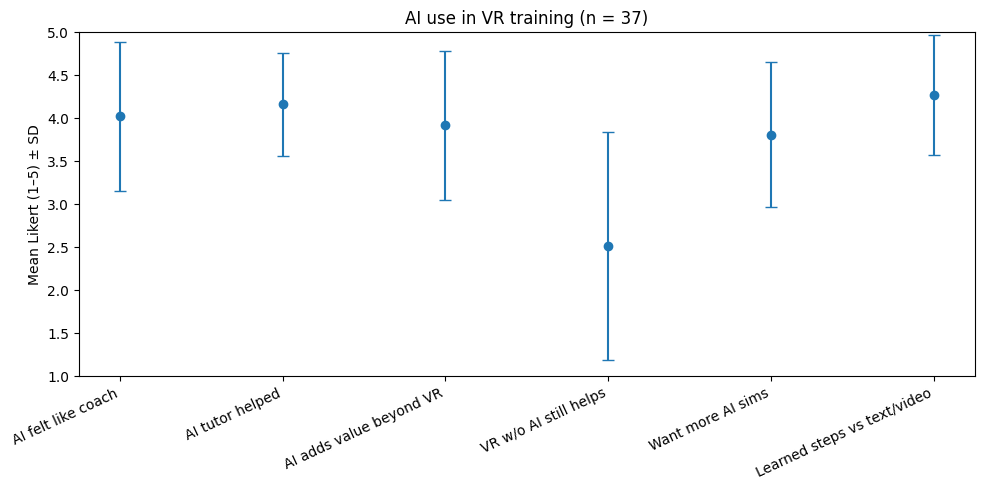


Exported tables:
- ai_vr_evidence_summary.csv
- ai_vr_group_means_by_vr_experience.csv

Open-ended feedback: AI-related snippets
AI-related feedback count: 8

[1] It could be more interactable physically. Everything was boxed into segmented steps. I would rather
an open environment that allows me to experiment at my own pace, questioning the AI when I needed
more information.

[2] The simulation is very visually engaging and realistic. The way individual pieces of equipment are
highlighted makes it easy to follow each task. The AI feature also enhances the experience by
providing real-time guidance, and makes the training feel more immersive and personalized.

[3] have the IA talk in a more human way or with some human like feature when it comes to talking. the
AI was very helpful but it felt like listing and old AI reading a audio book. overall this was a
educational video and it demonstrated how chips are package

[4] I really enjoy snippets of the video, it helped a lot with visual

In [2]:
# ===========================================================
# Goal: Extract/quantify evidence that AI use adds value in VR
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import textwrap

# ----------------------------
# 0) Load
# ----------------------------
CSV_PATH = "/content/drive/MyDrive/VR Responses 2025.csv"
df_raw = pd.read_csv(CSV_PATH)
print("Loaded:", df_raw.shape)

# ----------------------------
# CLEAN: drop non-analytic columns
# ----------------------------
drop_keywords = [
    "timestamp",
    "highest level of education",
    "current role",
    "field",
    "major",
    "email"
]

cols_to_drop = [
    c for c in df_raw.columns
    if any(k in c.lower() for k in drop_keywords)
]

print("\nDropping columns:")
for c in cols_to_drop:
    print("-", c)

df_raw = df_raw.drop(columns=cols_to_drop)
print("After drop:", df_raw.shape)

# ----------------------------
# 1) Rename columns to safe identifiers
# ----------------------------
rename_map = {
    "How would you rate your comfort with new technologies?\n\n1 = Strongly uncomfortable → 5 = Strongly comfortable": "tech_comfort",
    "How familiar are you with AI tools?\n\n1 = Not familiar at all → 5 = Very familiar": "ai_familiarity",
    "How often do you play video games?\n\n1 = Never → 5 = Very often": "video_games",
    "Have you used VR before?\n\n1 = Never → 5 = Very often": "vr_prior",

    "The AI felt like a helpful coach or instructor.\n\n1 = Strongly disagree → 5 = Strongly agree": "ai_coach",
    "The simulation was easy to follow.\n\n1 = Strongly disagree → 5 = Strongly agree": "easy_follow",
    "I found the simulation engaging.\n\n1 = Strongly disagree → 5 = Strongly agree": "engaging",
    "The simulation increased my understanding of the semiconductor process.\n\n1 = Strongly disagree → 5 = Strongly agree": "understanding",
    "The simulation increased my interest in semiconductor technology.\n\n1 = Strongly disagree → 5 = Strongly agree": "interest",

    # Columns directly supporting "AI adds value"
    "The AI tutor/assistant helped me understand what to do/improve...nductor process.\n\n1 = Strongly disagree → 5 = Strongly agree": "ai_tutor_helped",
    "The AI features added educational value beyond what the base V...lation provided.\n\n1 = Strongly disagree → 5 = Strongly agree": "ai_adds_value",
    "The VR simulation without AI features would still have helped ...ial effectively.\n\n1 = Strongly disagree → 5 = Strongly agree": "vr_without_ai_still_helps",
    "The simulation helped me learn the steps of the process more e... or video alone.\n\n1 = Strongly disagree → 5 = Strongly agree": "learn_steps_better_than_text",
    "I would like to use more AI-powered simulations in the future.\n\n1 = Strongly disagree → 5 = Strongly agree": "want_more_ai_sims",

    "Do you have any feedback you would like to share (for example, what worked well, what could be improved, or any suggestions)?": "feedback",
}


df = df_raw.copy()

def rename_by_contains(df_in, contains_str, new_name):
    """Find the first column containing contains_str and rename it to new_name."""
    matches = [c for c in df_in.columns if contains_str in c]
    if not matches:
        raise KeyError(f"Could not find a column containing: {contains_str}")
    df_in.rename(columns={matches[0]: new_name}, inplace=True)

# First rename exact matches that exist
existing = {k: v for k, v in rename_map.items() if k in df.columns}
df = df.rename(columns=existing)

# Then rename truncated ones by substring clues
if "ai_tutor_helped" not in df.columns:
    rename_by_contains(df, "The AI tutor/assistant helped me understand", "ai_tutor_helped")
if "ai_adds_value" not in df.columns:
    rename_by_contains(df, "The AI features added educational value", "ai_adds_value")
if "vr_without_ai_still_helps" not in df.columns:
    rename_by_contains(df, "The VR simulation without AI features would still have helped", "vr_without_ai_still_helps")
if "learn_steps_better_than_text" not in df.columns:
    rename_by_contains(df, "The simulation helped me learn the steps of the process", "learn_steps_better_than_text")

# Other Likert columns
if "ai_coach" not in df.columns:
    rename_by_contains(df, "The AI felt like a helpful coach", "ai_coach")
if "easy_follow" not in df.columns:
    rename_by_contains(df, "The simulation was easy to follow", "easy_follow")
if "engaging" not in df.columns:
    rename_by_contains(df, "I found the simulation engaging", "engaging")
if "understanding" not in df.columns:
    rename_by_contains(df, "increased my understanding", "understanding")
if "interest" not in df.columns:
    rename_by_contains(df, "increased my interest", "interest")
if "want_more_ai_sims" not in df.columns:
    rename_by_contains(df, "I would like to use more AI-powered simulations", "want_more_ai_sims")

# Background Likert columns
if "video_games" not in df.columns:
    rename_by_contains(df, "How often do you play video games", "video_games")
if "vr_prior" not in df.columns:
    rename_by_contains(df, "Have you used VR before", "vr_prior")
if "ai_familiarity" not in df.columns:
    rename_by_contains(df, "How familiar are you with AI tools", "ai_familiarity")
if "tech_comfort" not in df.columns:
    rename_by_contains(df, "How would you rate your comfort with new technologies", "tech_comfort")

# ----------------------------
# 2) Convert Likert columns to numeric
# ----------------------------
likert_like = [
    "tech_comfort", "ai_familiarity", "video_games", "vr_prior",
    "ai_coach", "easy_follow", "engaging", "understanding", "interest",
    "learn_steps_better_than_text", "ai_tutor_helped", "ai_adds_value",
    "vr_without_ai_still_helps", "want_more_ai_sims"
]
likert_like = [c for c in likert_like if c in df.columns]

for c in likert_like:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nColumns available for analysis:")
print(likert_like)

# ----------------------------
# 3) Helper summaries
# ----------------------------
def likert_summary(s):
    s = s.dropna()
    return pd.Series({
        "n": s.size,
        "mean": round(float(s.mean()), 2),
        "sd": round(float(s.std(ddof=1)), 2),
        "%>=4": round(float((s >= 4).mean() * 100), 1),
        "%==5": round(float((s == 5).mean() * 100), 1),
        "%<=2": round(float((s <= 2).mean() * 100), 1),
    })

def print_section(title):
    print("\n" + "="*90)
    print(title)
    print("="*90)

# ----------------------------
# 4) Evidence that AI adds value in VR
# ----------------------------
ai_evidence_cols = [
    "ai_coach",
    "ai_tutor_helped",
    "ai_adds_value",
    "vr_without_ai_still_helps",
    "want_more_ai_sims",
    "learn_steps_better_than_text"
]
ai_evidence_cols = [c for c in ai_evidence_cols if c in df.columns]

print_section("Overall AI-in-VR Evidence (descriptive stats)")
evidence_table = df[ai_evidence_cols].apply(likert_summary).T.sort_values("mean", ascending=False)
print(evidence_table)

# ----------------------------
# 5) AI adds value vs VR-only still helps
# ----------------------------
print_section("Ablation-style Signal: AI adds value vs VR-only still helps")
if "ai_adds_value" in df.columns and "vr_without_ai_still_helps" in df.columns:
    delta = df["ai_adds_value"] - df["vr_without_ai_still_helps"]
    print("Delta = ai_adds_value - vr_without_ai_still_helps")
    print(likert_summary(delta))
else:
    print("Missing required columns for delta computation.")

# ----------------------------
# 6) Group comparison: VR novices vs VR experienced (cutoff at >=3)
# ----------------------------
print_section("Group Comparison by Prior VR Experience (novice vs experienced)")
if "vr_prior" in df.columns:
    df["vr_group"] = np.where(df["vr_prior"] >= 3, "VR-experienced (3-5)", "VR-novice (1-2)")
    group_means = df.groupby("vr_group")[ai_evidence_cols].mean().round(2)
    print(group_means)
else:
    print("Missing vr_prior column.")

# ----------------------------
# 7) Regression models
# ----------------------------
def run_lm(formula, label):
    model = smf.ols(formula=formula, data=df).fit()
    print("\n" + "-"*90)
    print(label)
    print("Formula:", formula)
    print("Adj R^2:", round(model.rsquared_adj, 4))
    print(model.summary())
    return model

print_section("Regression: What predicts WANT MORE AI SIMS?")
predictors = [p for p in ["ai_adds_value", "ai_tutor_helped", "engaging", "vr_prior", "ai_familiarity"] if p in df.columns]
if "want_more_ai_sims" in df.columns and len(predictors) >= 2:
    formula = "want_more_ai_sims ~ " + " + ".join(predictors)
    lm_want = run_lm(formula, "Model A: want_more_ai_sims predicted by AI value/help + engagement + background")
else:
    print("Not enough columns to run model A.")

print_section("Regression: Does AI VALUE relate to LEARNING (understanding, steps, interest)?")
learning_outcomes = [o for o in ["understanding", "learn_steps_better_than_text", "interest"] if o in df.columns]
for outcome in learning_outcomes:
    preds = [p for p in ["ai_adds_value", "ai_tutor_helped", "easy_follow", "engaging", "vr_prior"] if p in df.columns]
    if len(preds) >= 2:
        run_lm(outcome + " ~ " + " + ".join(preds), f"Model B: {outcome} predicted by AI + usability")
    else:
        print(f"Not enough predictors for outcome {outcome}")

# ----------------------------
# 8) Plot: Mean ± SD
# ----------------------------
print_section("Plot: Mean ± SD for core AI-in-VR evidence items")

means = df[ai_evidence_cols].mean()
sds = df[ai_evidence_cols].std(ddof=1)

label_map = {
    "ai_coach": "AI felt like coach",
    "ai_tutor_helped": "AI tutor helped",
    "ai_adds_value": "AI adds value beyond VR",
    "vr_without_ai_still_helps": "VR w/o AI still helps",
    "want_more_ai_sims": "Want more AI sims",
    "learn_steps_better_than_text": "Learned steps vs text/video"
}
labels = [label_map.get(c, c) for c in ai_evidence_cols]

plt.figure(figsize=(10, 5))
x = np.arange(len(ai_evidence_cols))
plt.errorbar(x, means.values, yerr=sds.values, fmt="o", capsize=4)
plt.xticks(x, labels, rotation=25, ha="right")
plt.ylim(1, 5)
plt.ylabel("Mean Likert (1–5) ± SD")
plt.title("AI use in VR training (n = {})".format(len(df)))
plt.tight_layout()
plt.show()

# ----------------------------
# 9) Export summary tables
# ----------------------------
EXPORT = True
if EXPORT:
    evidence_table.to_csv("ai_vr_evidence_summary.csv", index=True)
    if "vr_group" in df.columns:
        group_means.to_csv("ai_vr_group_means_by_vr_experience.csv", index=True)
    print("\nExported tables:")
    print("- ai_vr_evidence_summary.csv")
    if "vr_group" in df.columns:
        print("- ai_vr_group_means_by_vr_experience.csv")

# ----------------------------
# 10) Open-ended feedback snippets mentioning AI/voice/usability
# ----------------------------
print_section("Open-ended feedback: AI-related snippets")
if "feedback" in df.columns:
    feedback = df["feedback"].fillna("").astype(str)
    ai_related = feedback[feedback.str.contains(r"\bAI\b|voice|tutor|assistant", case=False, regex=True)]
    print(f"AI-related feedback count: {len(ai_related)}")
    for i, txt in enumerate(ai_related.head(10).tolist(), 1):
        print(f"\n[{i}] {textwrap.fill(txt, 100)}")
else:
    print("No feedback column found.")


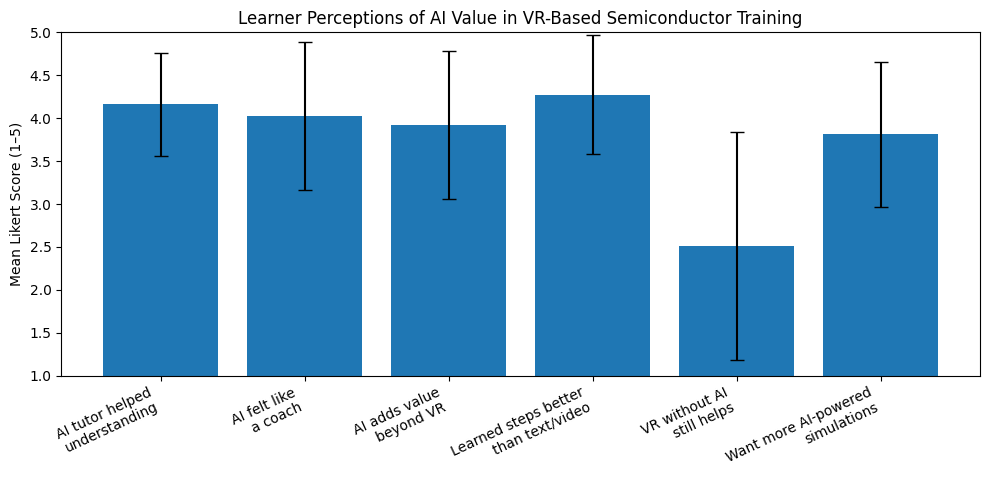

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Variables to plot
# ----------------------------
cols = [
    "ai_tutor_helped",
    "ai_coach",
    "ai_adds_value",
    "learn_steps_better_than_text",
    "vr_without_ai_still_helps",
    "want_more_ai_sims",
]

labels = [
    "AI tutor helped\nunderstanding",
    "AI felt like\na coach",
    "AI adds value\nbeyond VR",
    "Learned steps better\nthan text/video",
    "VR without AI\nstill helps",
    "Want more AI-powered\nsimulations",
]

means = df[cols].mean()
sds = df[cols].std(ddof=1)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(10, 5))
x = np.arange(len(cols))

plt.bar(x, means, yerr=sds, capsize=5)

plt.xticks(x, labels, rotation=25, ha="right")
plt.ylim(1, 5)
plt.ylabel("Mean Likert Score (1–5)")
plt.title("Learner Perceptions of AI Value in VR-Based Semiconductor Training")

plt.tight_layout()
plt.show()


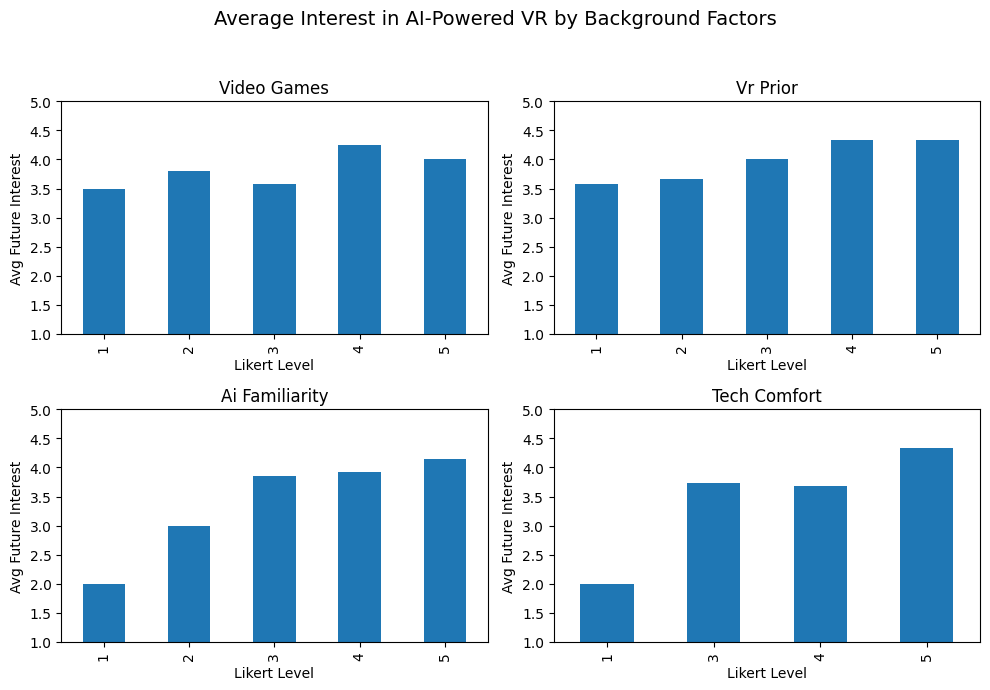

In [4]:
import matplotlib.pyplot as plt

group_vars = [
    "video_games",
    "vr_prior",
    "ai_familiarity",
    "tech_comfort"
]

target = "want_more_ai_sims"

# Compute group means
group_means = {}

for var in group_vars:
    grouped = df.groupby(var)[target].mean()
    group_means[var] = grouped

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for ax, var in zip(axes, group_vars):
    group_means[var].plot(kind="bar", ax=ax)
    ax.set_title(var.replace("_", " ").title())
    ax.set_xlabel("Likert Level")
    ax.set_ylabel("Avg Future Interest")
    ax.set_ylim(1, 5)

plt.suptitle("Average Interest in AI-Powered VR by Background Factors", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


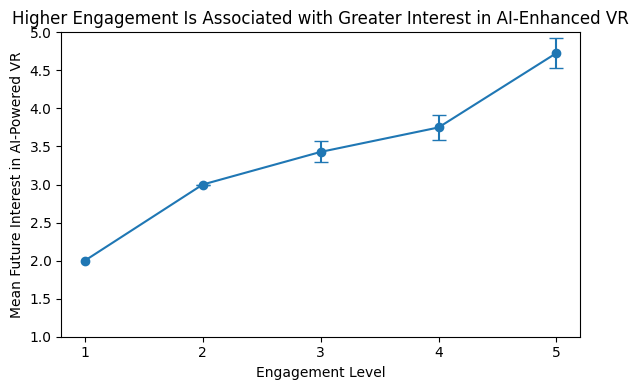

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Aggregate by engagement level
agg = (
    df.groupby("engaging")["want_more_ai_sims"]
      .agg(["mean", "count", "std"])
      .reset_index()
)

# Standard error
agg["se"] = agg["std"] / np.sqrt(agg["count"])

plt.figure(figsize=(6,4))
plt.errorbar(
    agg["engaging"],
    agg["mean"],
    yerr=agg["se"],
    fmt="o-",
    capsize=5
)

plt.xticks([1,2,3,4,5])
plt.ylim(1,5)
plt.xlabel("Engagement Level")
plt.ylabel("Mean Future Interest in AI-Powered VR")
plt.title("Higher Engagement Is Associated with Greater Interest in AI-Enhanced VR")
plt.tight_layout()
plt.show()


2024 shape: (29, 15)
2025 shape: (37, 20)

Standardized Engagement → Future Interest
-----------------------------------------
2024 (VR only): β = 0.81, R² = 0.66, n = 29
2025 (VR + AI): β = 0.78, R² = 0.61, n = 37


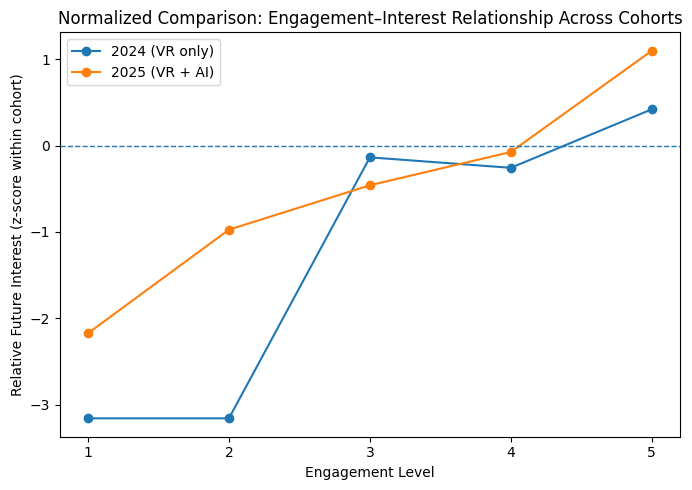

In [1]:
# ============================================================
# Cross-cohort comparison (2024 vs 2025) without comparing raw means
# Method:
#   1) Standardized regression: Engagement -> Future Interest (beta, R^2)
#   2) Within-cohort normalization (z-score) + plot of engagement vs relative interest
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ----------------------------
# 0) Load both CSVs
# ----------------------------
PATH_2024 = "/content/drive/MyDrive/START Form (Responses).csv"
PATH_2025 = "/content/drive/MyDrive/VR Responses 2025.csv"

df_2024 = pd.read_csv(PATH_2024)
df_2025 = pd.read_csv(PATH_2025)

print("2024 shape:", df_2024.shape)
print("2025 shape:", df_2025.shape)

# ----------------------------
# 1) Renaming helper
# ----------------------------
def rename_by_contains(df: pd.DataFrame, contains: str, new_name: str):
    matches = [c for c in df.columns if contains.lower() in c.lower()]
    if not matches:
        raise KeyError(f"Could not find a column containing: {contains}")
    df.rename(columns={matches[0]: new_name}, inplace=True)

# ----------------------------
# 2) Align comparable variables
# ----------------------------
rename_by_contains(df_2024, "future", "future_interest")
rename_by_contains(df_2025, "I would like to use more AI-powered", "future_interest")

rename_by_contains(df_2024, "engag", "engaging")
rename_by_contains(df_2025, "engaging", "engaging")

# Numeric conversion
for d in (df_2024, df_2025):
    d["future_interest"] = pd.to_numeric(d["future_interest"], errors="coerce")
    d["engaging"] = pd.to_numeric(d["engaging"], errors="coerce")

# ----------------------------
# 3) Standardized regression (beta, R^2)
#    Standardize x and y within each cohort -> compare beta slopes
# ----------------------------
def standardized_beta_and_r2(df: pd.DataFrame):
    sub = df[["engaging", "future_interest"]].dropna()
    if len(sub) < 3:
        return np.nan, np.nan, len(sub)

    x = (sub["engaging"] - sub["engaging"].mean()) / sub["engaging"].std(ddof=0)
    y = (sub["future_interest"] - sub["future_interest"].mean()) / sub["future_interest"].std(ddof=0)

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    beta = float(model.params.iloc[1])   # standardized slope
    r2 = float(model.rsquared)
    return beta, r2, len(sub)

beta_2024, r2_2024, n_2024 = standardized_beta_and_r2(df_2024)
beta_2025, r2_2025, n_2025 = standardized_beta_and_r2(df_2025)

print("\nStandardized Engagement → Future Interest")
print("-----------------------------------------")
print(f"2024 (VR only): β = {beta_2024:.2f}, R² = {r2_2024:.2f}, n = {n_2024}")
print(f"2025 (VR + AI): β = {beta_2025:.2f}, R² = {r2_2025:.2f}, n = {n_2025}")

# ----------------------------
# 4) Within-cohort normalization (z-score) and plot
# ----------------------------
def zscore(s: pd.Series):
    s = s.astype(float)
    return (s - s.mean()) / s.std(ddof=0)

df_2024["future_z"] = zscore(df_2024["future_interest"])
df_2025["future_z"] = zscore(df_2025["future_interest"])

agg_2024 = df_2024.groupby("engaging")["future_z"].mean().reset_index()
agg_2025 = df_2025.groupby("engaging")["future_z"].mean().reset_index()

plt.figure(figsize=(7, 5))

plt.plot(
    agg_2024["engaging"], agg_2024["future_z"],
    marker="o", label="2024 (VR only)"
)

plt.plot(
    agg_2025["engaging"], agg_2025["future_z"],
    marker="o", label="2025 (VR + AI)"
)

plt.axhline(0, linestyle="--", linewidth=1)

plt.xticks([1, 2, 3, 4, 5])
plt.xlabel("Engagement Level")
plt.ylabel("Relative Future Interest (z-score within cohort)")
plt.title("Normalized Comparison: Engagement–Interest Relationship Across Cohorts")
plt.legend()
plt.tight_layout()
plt.show()
